In [1]:
import pandas as pd
from playground.mypymorton import interleave3
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm
import matplotlib.animation as animation
import matplotlib
from hilbertcurve.hilbertcurve import HilbertCurve

matplotlib.rcParams['animation.embed_limit'] = 400

plt.style.use('seaborn-v0_8-pastel')

In [29]:
positions = pd.read_csv("../data/neuron_positions.csv")
positions.set_index("id")
positions.head(10)

max(max(positions["x"]), max(positions["y"]), max(positions["z"]))

186.67247

In [38]:

multiplier = 1_000_000
with_hilbert = positions.assign(hilbert=positions.apply(lambda x: interleave3([[int(multiplier*x.y), int(multiplier*x.x), int(multiplier*x.z)]]), axis=1))
ordered = with_hilbert.sort_values(by=["hilbert"])

# assert ordered.equals(ordered_zorder)
ordered["id"].to_csv("../data/zorder.csv", index=False, header=False)
assert ordered["hilbert"].is_unique
ordered
ordered.set_index(np.arange(ordered.shape[0]))

with open("../goserver/brain/zorder.txt", "w") as f:
    for i in ordered["id"]:
        f.write(f"{i} ")

In [4]:
pca = PCA(n_components=1)
pca.fit(positions[["x", "y", "z"]])
print(pca.components_)
pca_col = pca.transform(positions[["x", "y", "z"]])

pcad = positions.assign(pca=pca_col)
print(positions)

[[ 0.9190187  -0.09972566  0.38139142]]
          id          x           y          z  area_id
0          0  88.017654  143.889110  83.259131       43
1          1  88.071787  143.792200  83.237149       43
2          2  88.093434  143.951900  83.168331       43
3          3  88.063898  143.819810  83.317563       43
4          4  88.066131  143.973540  83.238470       43
...      ...        ...         ...        ...      ...
49995  49995  86.890937    1.931412  79.944581        3
49996  49996  86.764390    1.834104  80.037049        3
49997  49997  86.699561    1.970323  79.967185        3
49998  49998  86.841367    1.944717  80.029320        3
49999  49999  86.883557    2.006636  79.997225        3

[50000 rows x 5 columns]


100%|█████████▉| 49982/50000 [13:21<00:00, 33.75it/s] 

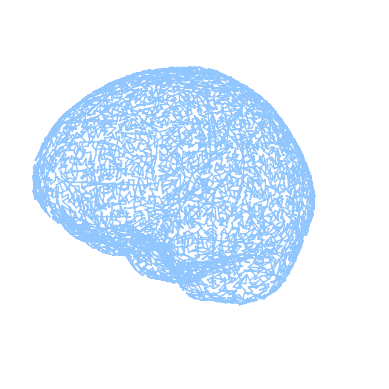

100%|█████████▉| 49991/50000 [13:40<00:00, 33.75it/s]

In [40]:
plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(projection="3d", xlim=(0, 150), ylim=(0, 150), zlim=(20, 130))
ax.view_init(elev=15., azim=60.)
area2 = ordered
# ax.scatter(area2.x, area2.y, area2.z, c=area2.index, cmap="rainbow", s=1)

x = ordered.x
y = ordered.y
z = ordered.z

walk = ordered[["x", "y", "z"]].to_numpy()
locations = positions[["x", "y", "z"]].to_numpy()
colors = plt.cm.rainbow(np.linspace(0, 1, len(x)))

line, = ax.plot([], [], [], lw=1)

j = 0

def init():
    line.set_data([], [])
    line.set_3d_properties([])
    return line,

def animate(i):
    global j

    while j != 0 and np.linalg.norm(locations[j] - locations[j - 1]) < 0.4:
        j += 1
        pbar.update(1)
    j += 1
    pbar.update(1)

    ax.view_init(elev=15., azim=-2 * 360 / frames * i + 60)
    line.set_data(walk[:j, :2].T)
    line.set_3d_properties(walk[:j, 2])
    return line,

plt.axis("off")

try:
    pbar.close()
except NameError:
    pass


frames = 5000
pbar = tqdm(total=50000)
anim = animation.FuncAnimation(fig, animate, init_func=init, 
							frames=frames, interval=13) 

with open("myvideo.html", "w") as f:
    print(anim.to_html5_video(embed_limit=200), file=f)
# pbar = tqdm(total=frames)
# callback = lambda current_frame, total_frames: pbar.update(1)
# anim.save('coil.mp4',writer='ffmpeg') 

plt.show()

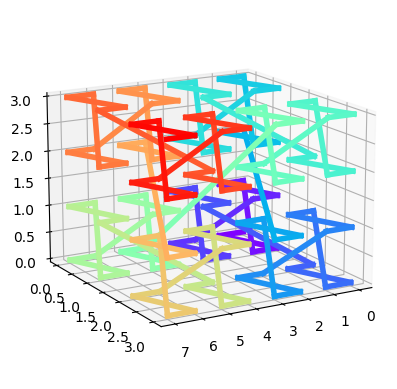

In [12]:
plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.view_init(elev=15., azim=60.)


def __unpart1by2_64(n):
    n &= 0x1249249249249249                  # binary: 1001001001001001001001001001001001001001001001001001001001001, len: 61
    n = (n ^ (n >> 2))  & 0x10c30c30c30c30c3 # binary: 1000011000011000011000011000011000011000011000011000011000011, len: 61
    n = (n ^ (n >> 4))  & 0x100f00f00f00f00f # binary: 1000000001111000000001111000000001111000000001111000000001111, len: 61
    n = (n ^ (n >> 8))  & 0x1f0000ff0000ff   # binary: 11111000000000000000011111111000000000000000011111111,         len: 53
    n = (n ^ (n >> 16)) & 0x1f00000000ffff   # binary: 11111000000000000000000000000000000001111111111111111,         len: 53
    n = (n ^ (n >> 32)) & 0x1fffff           # binary: 111111111111111111111,                                         len: 21
    return n

def deinterleave3(n):
    if not isinstance(n, int):
        print('Usage: deinterleave2(n)')
        raise ValueError("Supplied arguments contain a non-integer!")

    return __unpart1by2_64(n), __unpart1by2_64(n >> 1), __unpart1by2_64(n >> 2)

for i in range(100000):
    assert i == interleave3(*deinterleave3(i)), (i, interleave3(*deinterleave3(i)), deinterleave3(i))

m = 7
N = 2**m - 1
colors = plt.cm.rainbow(np.linspace(0, 1, N))

# plot z order morton curve
for i in range(0, N):
    x1, y1, z1 = deinterleave3(i)
    x2, y2, z2 = deinterleave3(i + 1)
    ax.plot([x1, x2], [y1, y2], [z1, z2], "-", color=colors[i], lw=4)

plt.show()
